In [7]:
import os,joblib,random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
accuracy_score, precision_score, recall_score,
f1_score, roc_auc_score, average_precision_score
)

device= torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
path= "/kaggle/input/exotraincsv/exoTrain.csv"

In [9]:
class Exodata(Dataset):
    def __init__(self,x,y):
        self.x= x.astype(np.float32)
        self.y= y.astype(np.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        x= self.x[idx]
        x = torch.from_numpy(x)[None, :]
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        return x, y


In [10]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack= nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=11, padding=5),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            nn.Conv1d(32, 64, kernel_size=9, padding=4),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            nn.Conv1d(64, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

        self.classifier=  nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x=self.stack(x)
        x= self.classifier(x).squeeze(1)
        return x

In [11]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha= alpha
        self.gamma= gamma
        self.reduction= reduction

    def forward(self, logits, targets):
        bce= nn.functional.binary_cross_entropy_with_logits(logits, targets, reduction="none")
        p= torch.sigmoid(logits)
        pt=torch.where(targets == 1, p, 1-p)
        loss= self.alpha*(1-pt)**self.gamma * bce

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss

In [12]:
BATCH_SIZE = 64
EPOCHS     = 30
LR         = 0.001
PATIENCE   = 5
USE_FOCAL  = False   

df = pd.read_csv(path)
y  = (df['LABEL'] == 1).astype(np.int32).values
X  = df.drop(columns=['LABEL']).values


X = np.nan_to_num(X, nan=np.nanmedian(X))
med = np.median(X, axis=1, keepdims=True)
Xc  = X - med
mad = np.median(np.abs(Xc), axis=1, keepdims=True); mad[mad==0]=1.0
Xr  = Xc / mad

X_train, X_temp, y_train, y_temp = train_test_split(Xr, y, test_size=0.2, random_state=42, stratify=y)
X_val,   X_test, y_val,   y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

joblib.dump(scaler, "scaler.pkl")

train_loader = DataLoader(Exodata(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(Exodata(X_val,   y_val),   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(Exodata(X_test,  y_test),  batch_size=BATCH_SIZE, shuffle=False)

In [13]:
model = CNN().to(device)

# pos_weight for imbalance
pos = y_train.sum(); neg = len(y_train) - pos
pos_weight = torch.tensor([neg / (pos + 1e-12)], dtype=torch.float32, device=device)

bce_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
criterion = FocalLoss() if USE_FOCAL else bce_loss

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

def evaluate(model, loader):
    model.eval()
    all_prob, all_y = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device); yb = yb.to(device)
            logits = model(xb)
            prob   = torch.sigmoid(logits).detach().cpu().numpy()
            all_prob.append(prob); all_y.append(yb.detach().cpu().numpy())
    prob = np.concatenate(all_prob).ravel()
    ytrue= np.concatenate(all_y).ravel().astype(int)
    yhat = (prob >= 0.5).astype(int)
    return {
        "acc": accuracy_score(ytrue, yhat),
        "prec": precision_score(ytrue, yhat, zero_division=0),
        "rec": recall_score(ytrue, yhat, zero_division=0),
        "f1": f1_score(ytrue, yhat, zero_division=0),
        "roc": roc_auc_score(ytrue, prob),
        "pr":  average_precision_score(ytrue, prob),
        "y": ytrue, "p": prob
    }

best_pr = -np.inf
best_state = None
pat = 0

for epoch in range(1, EPOCHS+1):
    model.train()
    running = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device); yb = yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        running += loss.item() * xb.size(0)

    val_metrics = evaluate(model, val_loader)
    scheduler.step(val_metrics["pr"])
    print(f"Epoch {epoch:02d} | loss {running/len(train_loader.dataset):.4f} | "
          f"val PR {val_metrics['pr']:.4f} | ROC {val_metrics['roc']:.4f}")

    if val_metrics["pr"] > best_pr + 1e-6:
        best_pr = val_metrics["pr"]; pat = 0
        best_state = {"model": model.state_dict()}
        torch.save(best_state, "model.pth")
        print("> saved best model")
    else:
        pat += 1
        if pat >= PATIENCE:
            print("Early stopping."); break

if best_state is not None:
    model.load_state_dict(best_state["model"])
else:
    torch.save({"model": model.state_dict()}, "model.pth")

Epoch 01 | loss 0.0102 | val PR 0.9965 | ROC 0.6693
> saved best model
Epoch 02 | loss 0.0089 | val PR 0.9968 | ROC 0.6522
> saved best model
Epoch 03 | loss 0.0088 | val PR 0.9988 | ROC 0.8340
> saved best model
Epoch 04 | loss 0.0087 | val PR 0.9976 | ROC 0.7003
Epoch 05 | loss 0.0084 | val PR 0.9975 | ROC 0.6957
Epoch 06 | loss 0.0076 | val PR 0.9989 | ROC 0.8432
> saved best model
Epoch 07 | loss 0.0074 | val PR 0.9990 | ROC 0.8564
> saved best model
Epoch 08 | loss 0.0079 | val PR 0.9994 | ROC 0.9104
> saved best model
Epoch 09 | loss 0.0069 | val PR 0.9993 | ROC 0.8999
Epoch 10 | loss 0.0073 | val PR 0.9998 | ROC 0.9611
> saved best model
Epoch 11 | loss 0.0071 | val PR 0.9990 | ROC 0.8603
Epoch 12 | loss 0.0065 | val PR 0.9995 | ROC 0.9216
Epoch 13 | loss 0.0059 | val PR 0.9985 | ROC 0.8024
Epoch 14 | loss 0.0056 | val PR 0.9997 | ROC 0.9559
Epoch 15 | loss 0.0056 | val PR 0.9999 | ROC 0.9862
> saved best model
Epoch 16 | loss 0.0050 | val PR 0.9992 | ROC 0.8841
Epoch 17 | loss 

In [14]:
class ModelWithTemperature(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1))
    def forward(self, x):
        return self.model(x) / self.temperature
    def set_temperature(self, loader):
        self.to(device)
        crit = nn.BCEWithLogitsLoss()
        logits_list, labels_list = [], []
        self.eval()
        with torch.no_grad():
            for xb, yb in loader:
                xb = xb.to(device)
                logits_list.append(self.model(xb).detach().cpu())
                labels_list.append(yb)
        logits = torch.cat(logits_list).squeeze()
        labels = torch.cat(labels_list).to(torch.float32).squeeze()
        T = torch.ones(1, requires_grad=True, device=device)
        opt = torch.optim.LBFGS([T], lr=0.01, max_iter=50)
        def closure():
            opt.zero_grad()
            loss = crit(logits.to(device)/T, labels.to(device))
            loss.backward();
            return loss.item()
        opt.step(closure)
        self.temperature.data = T.data
        return float(self.temperature.item())

model_ts = ModelWithTemperature(model)
T = model_ts.set_temperature(val_loader)
np.save("temperature.npy", np.array([float(T)]))
print(f"Calibrated temperature: {float(T):.4f}")

Calibrated temperature: 1.0056


In [15]:
@torch.no_grad()
def predict_with_temp(model_with_temp, loader):
    model_with_temp.eval()
    probs, ys = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        logits = model_with_temp(xb)
        probs.append(torch.sigmoid(logits).cpu().numpy())
        ys.append(yb.numpy())
    return np.concatenate(ys).ravel().astype(int), np.concatenate(probs).ravel()

y_true, y_prob = predict_with_temp(model_ts, test_loader)

def print_metrics(y_true, y_prob, thr=0.5):
    y_hat = (y_prob >= thr).astype(int)
    m = dict(
        acc = accuracy_score(y_true, y_hat),
        prec= precision_score(y_true, y_hat, zero_division=0),
        rec = recall_score(y_true, y_hat, zero_division=0),
        f1  = f1_score(y_true, y_hat, zero_division=0),
        roc = roc_auc_score(y_true, y_prob),
        pr  = average_precision_score(y_true, y_prob),
    )
    print({k: round(v,4) for k,v in m.items()}); return m

print("Test (calibrated) metrics:")
_ = print_metrics(y_true, y_prob, 0.5)


Test (calibrated) metrics:
{'acc': 0.8998, 'prec': 1.0, 'rec': 0.899, 'f1': 0.9468, 'roc': 0.9856, 'pr': 0.9999}


In [16]:
def saliency_map(model_core, x_np):
    model_core.eval()
    x = torch.tensor(x_np.astype(np.float32)).unsqueeze(0).unsqueeze(0).to(device)
    x.requires_grad_()
    logits = model_core(x)
    logits.backward() # this is new
    sal = x.grad.detach().cpu().squeeze().numpy()
    return np.abs(sal)

K = min(3, len(X_test))
sals = [saliency_map(model_ts.model, X_test[i]) for i in range(K)]
np.save("saliency_examples.npy", np.stack(sals, axis=0))
print("Saved saliency_examples.npy")


Saved saliency_examples.npy


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, average_precision_score, roc_auc_score
import numpy as np

def plot_pr_roc_curves(y_true, y_prob, figsize=(14, 6)):
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)

    ax1.plot(recall, precision, color='dodgerblue', lw=2, label=f'PR Curve (AUC = {pr_auc:.4f})')

    no_skill = len(y_true[y_true==1]) / len(y_true)
    ax1.axhline(y=no_skill, color='gray', linestyle='--', label='No-Skill Classifier')
    ax1.set_xlabel('Recall (Sensitivity)')
    ax1.set_ylabel('Precision')
    ax1.set_title('Precision-Recall Curve')
    ax1.legend(loc='lower left')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])

   
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = roc_auc_score(y_true, y_prob)

    ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
   
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Chance')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate (Recall)')
    ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax2.legend(loc='lower right')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])

    plt.tight_layout()
    plt.show()

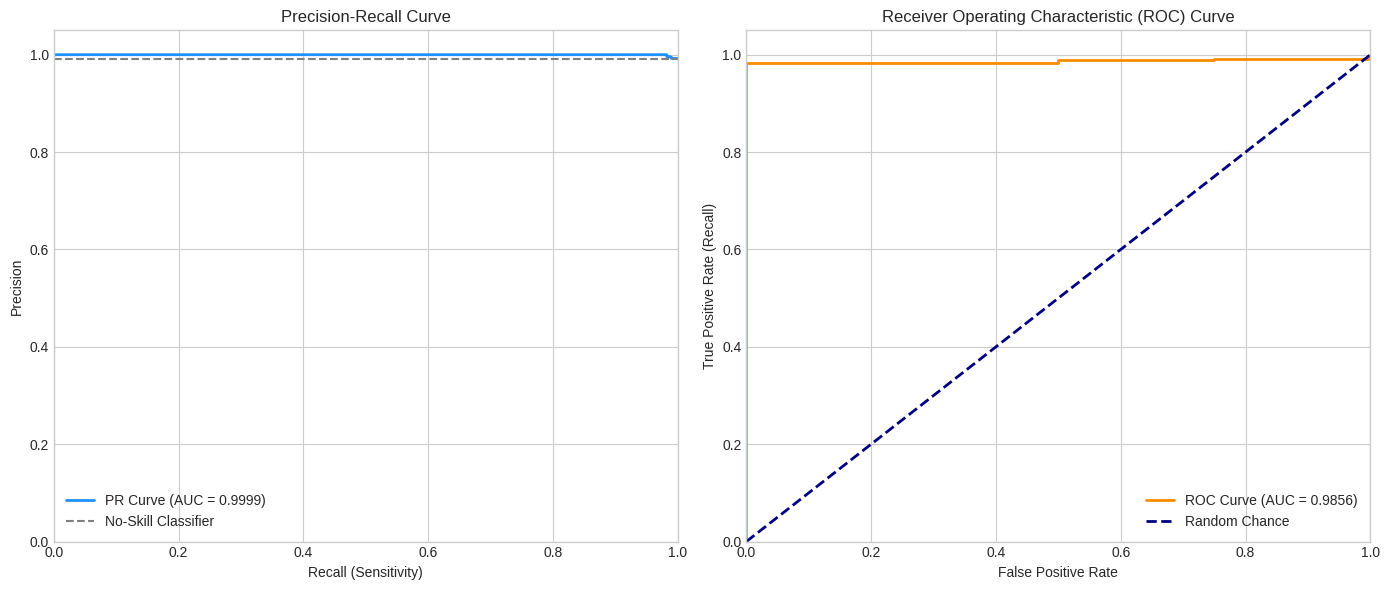

In [18]:
plot_pr_roc_curves(y_true, y_prob)